In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


# MNIST

* Entropia Global das Imagens (Entropia Aplicada Diretamente flatten)



# Apartir daqui aplicamos entropia no filtro de validação também (o v09) não executa essa ação.

## Criação e definição de todas as funções

1.   Filtro de Entropia
2.   Carregamento, Preprocesssamento e Tratamento
3.   Criação do Modelo
4.   Predições Estatisticas
5.   Plot de Acuracy e Loss

In [3]:
from keras.datasets import mnist
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
#from keras.src.utils.np_utils import to_categorical
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

def filtrar_entropia_median(train_X, train_y):  # filtro de entropia
    base = 2 # base de logaritimo
    tuplasEntropia = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(train_X)] #operacao de flaten sob base para calcular entropia e enumerar
    entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
    n = len(entropiesLocal_ordenado)
    if n % 2 == 1:
        median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
    else:
        median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
    indices_filtrados = [item[0] for item in entropiesLocal_ordenado if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    train_y = np.array([train_y[i] for i in indices_filtrados]) # passa os indices selecionados para base de labels
    return train_X, train_y

def filtrar_entropia_median_train_teste(train_X, train_y, test_X, test_y):  # filtro de entropia
    base = 2 # base de logaritimo
    tuplasEntropia = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(train_X)] #operacao de flaten sob base para calcular entropia e enumerar
    tuplasEntropiaTeste = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(test_X)] #operacao de flaten sob base para calcular entropia e enumerar
    entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
    entropiesLocal_ordenadoTeste = sorted(tuplasEntropiaTeste, key=lambda x: x[1]) #ordenação com base na entropia
    n = len(entropiesLocal_ordenado)
    if n % 2 == 1:
        median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
    else:
        median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
    indices_filtrados = [item[0] for item in entropiesLocal_ordenado if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    indices_filtradosTeste = [item[0] for item in entropiesLocal_ordenadoTeste if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    train_y = np.array([train_y[i] for i in indices_filtrados]) # passa os indices selecionados para base de labels
    test_X = np.array([test_X[i] for i in indices_filtradosTeste]) # passa os indices selecionados para base de treino
    test_y = np.array([test_y[i] for i in indices_filtradosTeste]) # passa os indices selecionados para base de labels    
    return train_X, train_y, test_X, test_y

def carregarPeparar(train_X, train_y, test_X, test_y, d, c): # Carregamento e Tratamento
  train_X = train_X.reshape((train_X.shape[0], d, d, c))   # Ajuste da dimensão
  test_X = test_X.reshape((test_X.shape[0], d, d, c))    # Ajuste da dimensão
  train_X = train_X.astype("float")/255.0     # Normalização
  test_X = test_X.astype("float")/255.0     # Normalização
  train_y = to_categorical(train_y, 10) #10 classes possiveis   -   # to Categorical para as classes
  test_y = to_categorical(test_y, 10) #10 classes possiveis     -   # to Categorical para as classes
  return train_X, train_y, test_X, test_y

def avaliacao_statistica(test_X, test_y):
    predictions = model.predict(test_X) # Previsões
    classePredita = np.argmax(predictions, axis=1)
    classeVerdadeira = np.argmax(test_y, axis=1)
    cm = confusion_matrix(classeVerdadeira, classePredita)
    ConfusionMatrixDisplay(cm).plot()  # classePredita para matrix de confusao
    acc = accuracy_score(classeVerdadeira, classePredita) * 100  # Acuracia
    print("Acuracia: ", '%.3f' % (acc*1.0))
    sens = recall_score(classeVerdadeira, classePredita, average='macro')  # Sensibilidade
    print("Sensibilidade: ", '%.3f' % (sens*1.0))

def plotAcuraciaLoss(history): #plots
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro gráfico  # Primeiro gráfico (accuracy)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo gráfico # Segundo gráfico (loss)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.tight_layout() # Exibir os gráficos

def plotarDadosTrain(index_inicio, qtd, train_X): # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
  base = 330
  import matplotlib.pyplot as plt
  for i in range(index_inicio, index_inicio + qtd):
      plt.subplot(base + 1 + (i - index_inicio))
      plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
  plt.show()
  print(train_y[index_inicio:index_inicio + qtd])

def tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF = None): # x = time.time() || inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
  elapsed_time = [["Carregar DataSet", 0], ["Filtro Entropia", 0], ["Pre-processamento", 0], ["Criação do Modelo", 0], ["Treinamento", 0], ["Inicio à Fim Execução" , 0]]
  elapsed_time[0][1] = importacaoF - inicio  # tempo de inicio de execução até o final da importação do dataset
  if (entropiaF != None): elapsed_time[1][1] = entropiaF - importacaoF  # Tempo gasto Inicio é importaçãoF - Execução da Entropia
  elapsed_time[2][1] = padrozinacaoF - importacaoF  # pega o tempo da entropia e subtrai do tempo apos a padronização para verificar quanto tempo padronizacao demorou
  elapsed_time[3][1] = criacaoModeloF - padrozinacaoF  # tempo da padronizacao - tempo apos a criacao do modelo para verificar tempo decorido
  elapsed_time[4][1] = treinamentoF - criacaoModeloF  # tempo inicial é marcado pela criacaoModeloF - tempoTreinamento que marca o momento que treinamento terminou
  elapsed_time[5][1] = treinamentoF - inicio #tempo total de execução inicio| importações até final da Execução | treinamento
  for index, tempo in enumerate(elapsed_time):
    if entropiaF is None and index == 1:
      continue
    print("{}: {:.4f}".format(tempo[0], round(tempo[1], 2)) + str(" em milissegundos"))

### [MNIST]Treinamento e ordem de execução das funções
  * **[Modelo da CNN para MNIST]**

In [4]:
def criacaoModeloF1(): # Criação do Modelo
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_uniform', input_shape = (28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'softmax'))  # classificação 10 categorias

  opt = SGD(learning_rate=0.01, momentum =0.9) #copilaçãoModelo
  model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics= ['accuracy'])
  return model

### [MNIST]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Completo]**

Epoch 1/10
1875/1875 [==============================] - 24s 12ms/step - loss: 0.3274 - accuracy: 0.9010 - val_loss: 0.0655 - val_accuracy: 0.9802
Epoch 2/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1266 - accuracy: 0.9643 - val_loss: 0.0397 - val_accuracy: 0.9879
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0886 - accuracy: 0.9753 - val_loss: 0.0428 - val_accuracy: 0.9883
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0712 - accuracy: 0.9808 - val_loss: 0.0390 - val_accuracy: 0.9902
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0605 - accuracy: 0.9829 - val_loss: 0.0421 - val_accuracy: 0.9906
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0506 - accuracy: 0.9858 - val_loss: 0.0340 - val_accuracy: 0.9907
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0459 - accuracy: 0.9870 - val_loss: 0.0345 -

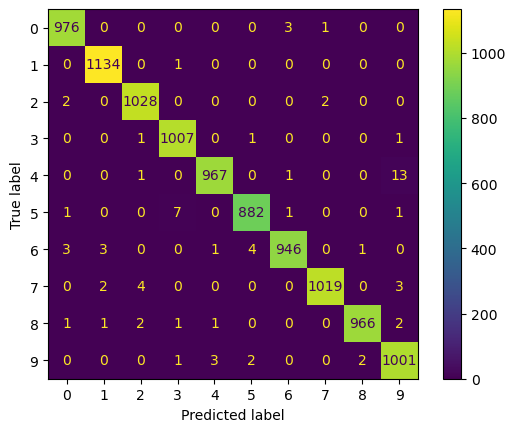

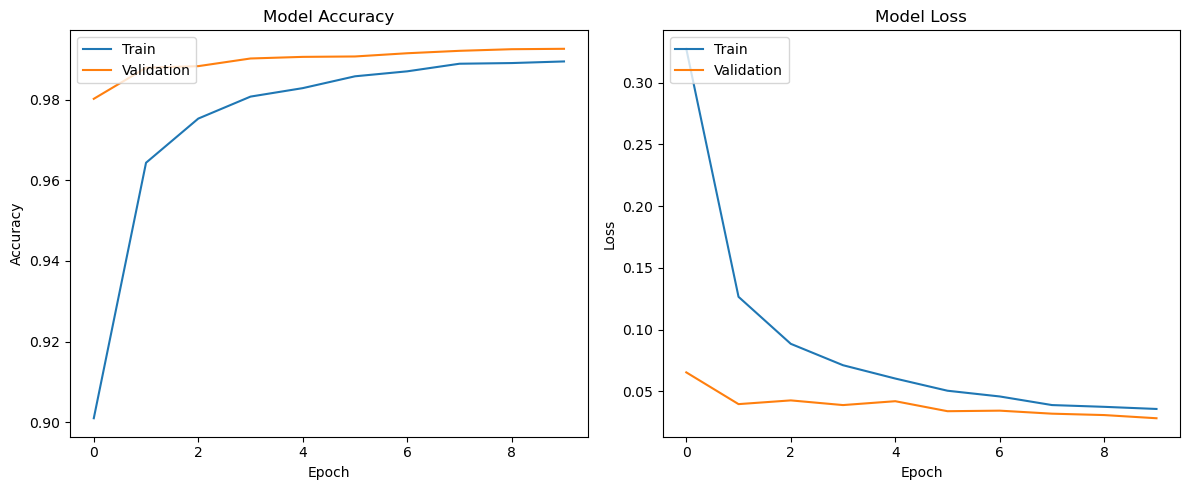

In [8]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### [MNIST]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Divido na metade e aletatorio]**

Epoch 1/10
938/938 [==============================] - 12s 12ms/step - loss: 2.3151 - accuracy: 0.1126 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 2/10
938/938 [==============================] - 12s 13ms/step - loss: 2.3017 - accuracy: 0.1117 - val_loss: 2.3012 - val_accuracy: 0.1191
Epoch 3/10
938/938 [==============================] - 13s 13ms/step - loss: 2.3018 - accuracy: 0.1135 - val_loss: 2.3027 - val_accuracy: 0.1041
Epoch 4/10
938/938 [==============================] - 12s 13ms/step - loss: 2.3020 - accuracy: 0.1137 - val_loss: 2.3030 - val_accuracy: 0.1091
Epoch 5/10
938/938 [==============================] - 12s 12ms/step - loss: 2.3016 - accuracy: 0.1134 - val_loss: 2.3054 - val_accuracy: 0.1030
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 2.3013 - accuracy: 0.1120 - val_loss: 2.2995 - val_accuracy: 0.1123
Epoch 7/10
938/938 [==============================] - 12s 13ms/step - loss: 2.3015 - accuracy: 0.1130 - val_loss: 2.3019 - val_accuracy:

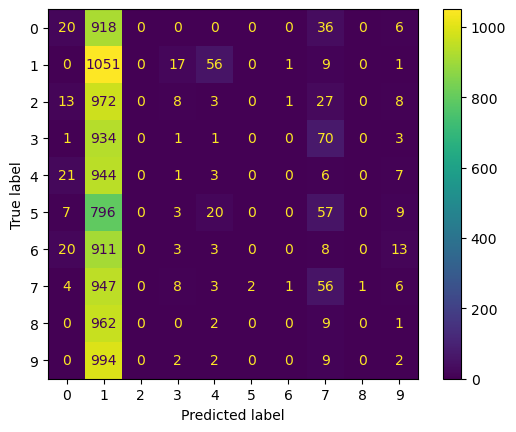

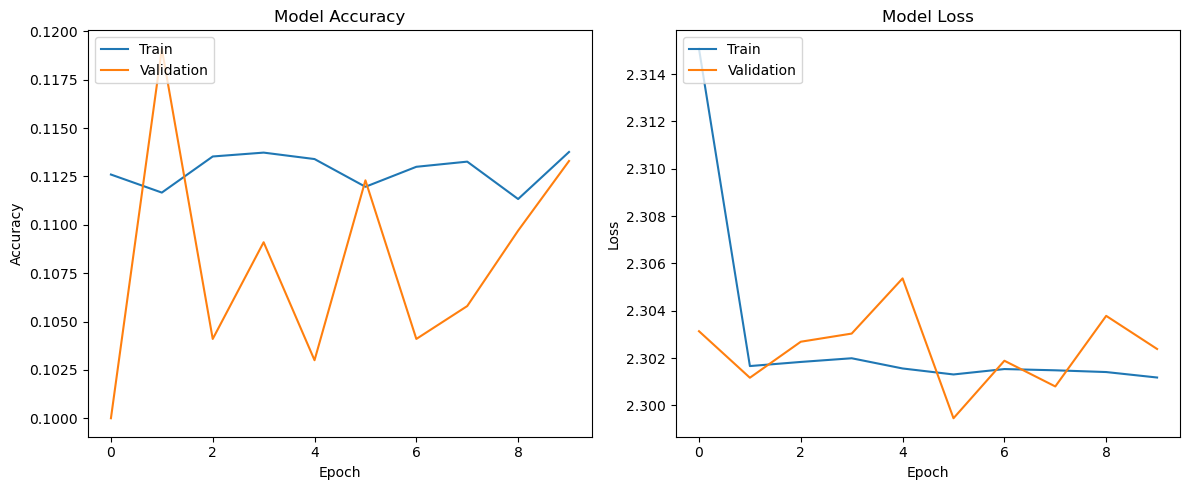

In [6]:
from sklearn.model_selection import train_test_split
import random
def selecionar_metade_aleatoria(metade1, metade2):
    return metade1 if random.choice([True, False]) else metade2

inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
metade_train_X, outra_metade_train_X, metade_train_y, outra_metade_train_y = train_test_split(train_X, train_y, test_size=0.5, random_state=42) # Corte aleatorio do dataset na metade
train_X = selecionar_metade_aleatoria(metade_train_X, outra_metade_train_X)
train_y = selecionar_metade_aleatoria(metade_train_y, outra_metade_train_y)

importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

## [MNIST]Treinamento e ordem de execução das funções
 * **[Modelo selecionado com entropia]**
 * **Baixa Entropia**

### Filtro de entropia :
  * Dataset filtrado
  * Baixa Entropia

Epoch 1/10
938/938 [==============================] - 13s 13ms/step - loss: 0.4631 - accuracy: 0.8577 - val_loss: 0.1029 - val_accuracy: 0.9683
Epoch 2/10
938/938 [==============================] - 13s 14ms/step - loss: 0.1961 - accuracy: 0.9444 - val_loss: 0.0696 - val_accuracy: 0.9804
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 0.1398 - accuracy: 0.9621 - val_loss: 0.0874 - val_accuracy: 0.9772
Epoch 4/10
938/938 [==============================] - 12s 13ms/step - loss: 0.1089 - accuracy: 0.9700 - val_loss: 0.0558 - val_accuracy: 0.9850
Epoch 5/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0958 - accuracy: 0.9742 - val_loss: 0.0835 - val_accuracy: 0.9805
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0835 - accuracy: 0.9766 - val_loss: 0.0477 - val_accuracy: 0.9861
Epoch 7/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0693 - accuracy: 0.9798 - val_loss: 0.0572 - val_accuracy:

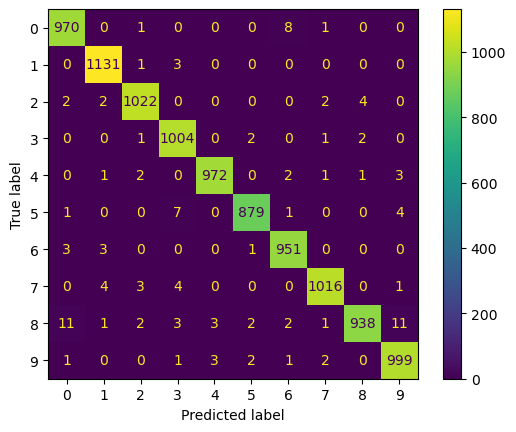

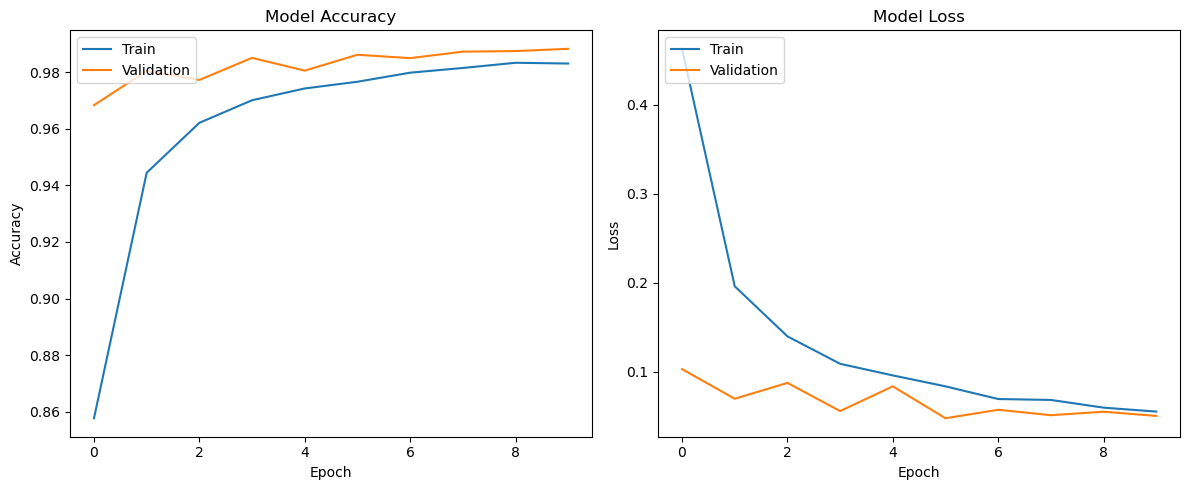

In [10]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados de treino
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### Filtro de entropia :
  * Dataset filtrado
  * Median transferida para conjunto de treino e teste

Epoch 1/10
938/938 [==============================] - 13s 13ms/step - loss: 0.4707 - accuracy: 0.8498 - val_loss: 0.0814 - val_accuracy: 0.9770
Epoch 2/10
938/938 [==============================] - 11s 12ms/step - loss: 0.1974 - accuracy: 0.9429 - val_loss: 0.0709 - val_accuracy: 0.9826
Epoch 3/10
938/938 [==============================] - 11s 11ms/step - loss: 0.1422 - accuracy: 0.9591 - val_loss: 0.0685 - val_accuracy: 0.9793
Epoch 4/10
938/938 [==============================] - 11s 12ms/step - loss: 0.1133 - accuracy: 0.9672 - val_loss: 0.0468 - val_accuracy: 0.9888
Epoch 5/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0905 - accuracy: 0.9748 - val_loss: 0.0402 - val_accuracy: 0.9901
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0813 - accuracy: 0.9765 - val_loss: 0.0453 - val_accuracy: 0.9894
Epoch 7/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0713 - accuracy: 0.9790 - val_loss: 0.0570 - val_accuracy:

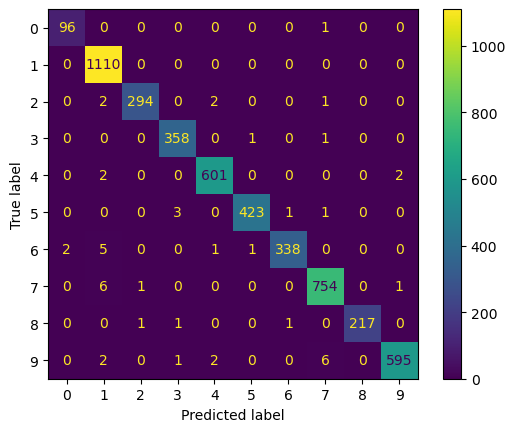

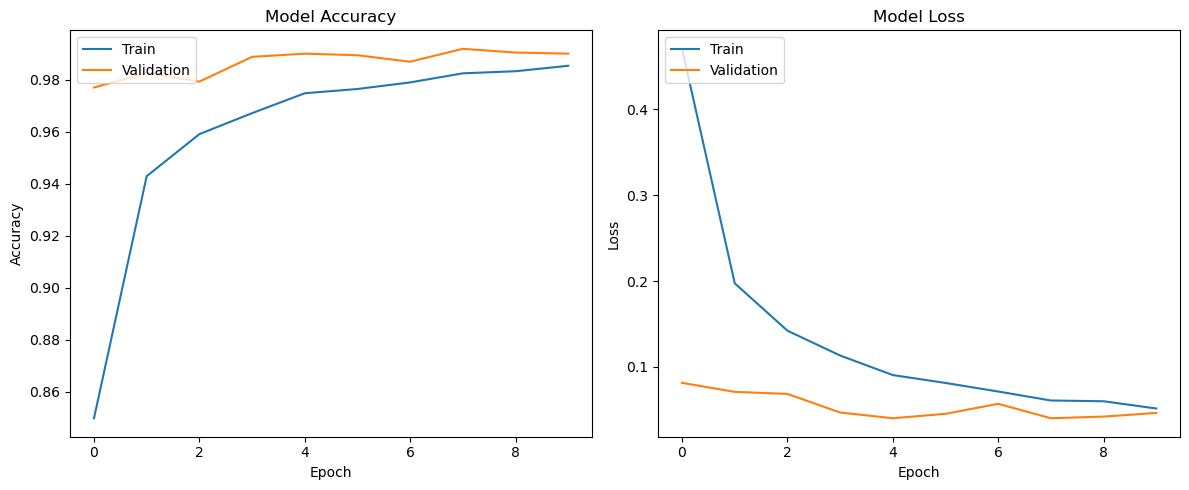

In [7]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = filtrar_entropia_median_train_teste(train_X, train_y, test_X, test_y) #novo filtro da reunião 03-10-2023
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### Filtro de entropia :
  * Dataset filtrado
  * Median transferida para conjunto de treino
  * Cross-validation

Treinando a rede no folder numero: 1
Epoch 1/10
750/750 [==============================] - 10s 12ms/step - loss: 0.4780 - accuracy: 0.8508 - val_loss: 0.1981 - val_accuracy: 0.9402
Epoch 2/10
750/750 [==============================] - 10s 13ms/step - loss: 0.2193 - accuracy: 0.9370 - val_loss: 0.0778 - val_accuracy: 0.9767
Epoch 3/10
750/750 [==============================] - 14s 19ms/step - loss: 0.1521 - accuracy: 0.9552 - val_loss: 0.0823 - val_accuracy: 0.9787
Epoch 4/10
750/750 [==============================] - 12s 17ms/step - loss: 0.1223 - accuracy: 0.9648 - val_loss: 0.0713 - val_accuracy: 0.9828
Epoch 5/10
750/750 [==============================] - 13s 18ms/step - loss: 0.1085 - accuracy: 0.9693 - val_loss: 0.0861 - val_accuracy: 0.9807
Epoch 6/10
750/750 [==============================] - 14s 19ms/step - loss: 0.0861 - accuracy: 0.9744 - val_loss: 0.0658 - val_accuracy: 0.9868
Epoch 7/10
750/750 [==============================] - 11s 14ms/step - loss: 0.0803 - accuracy: 0.97

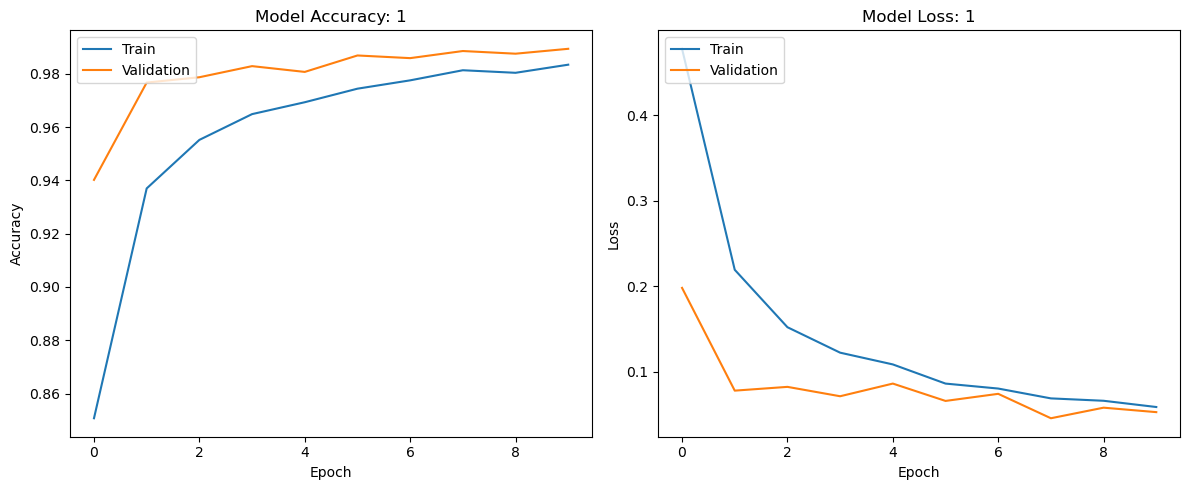

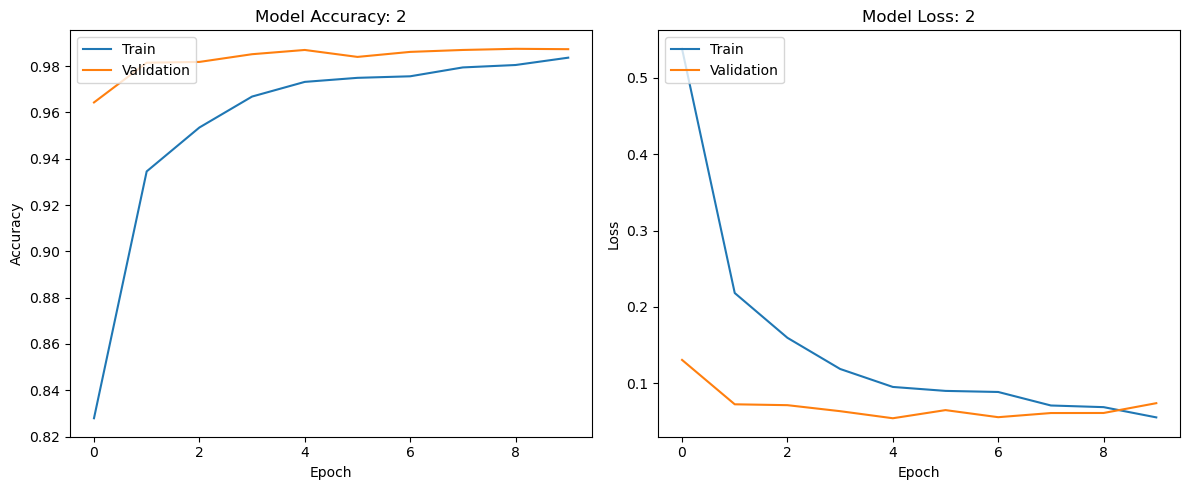

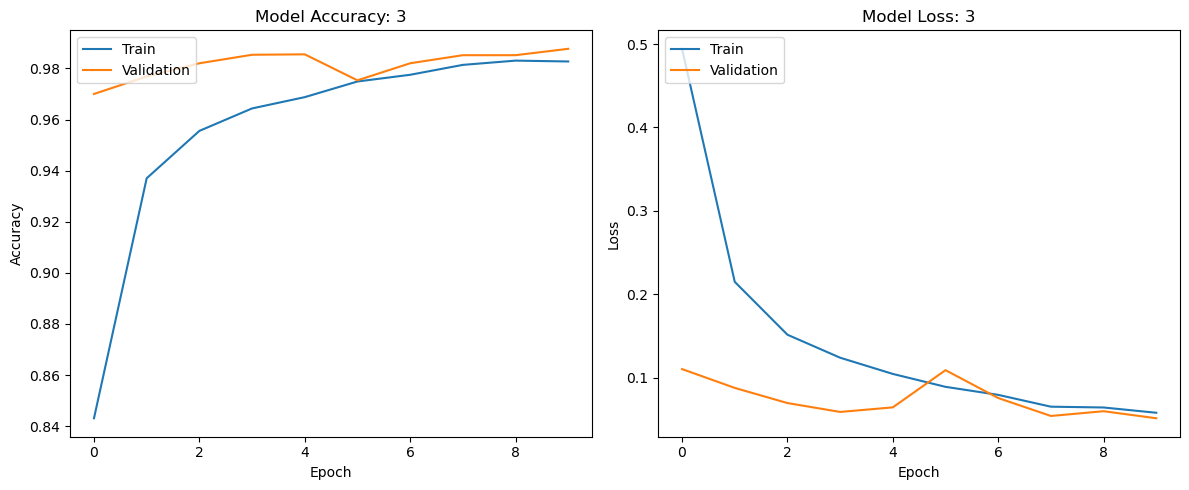

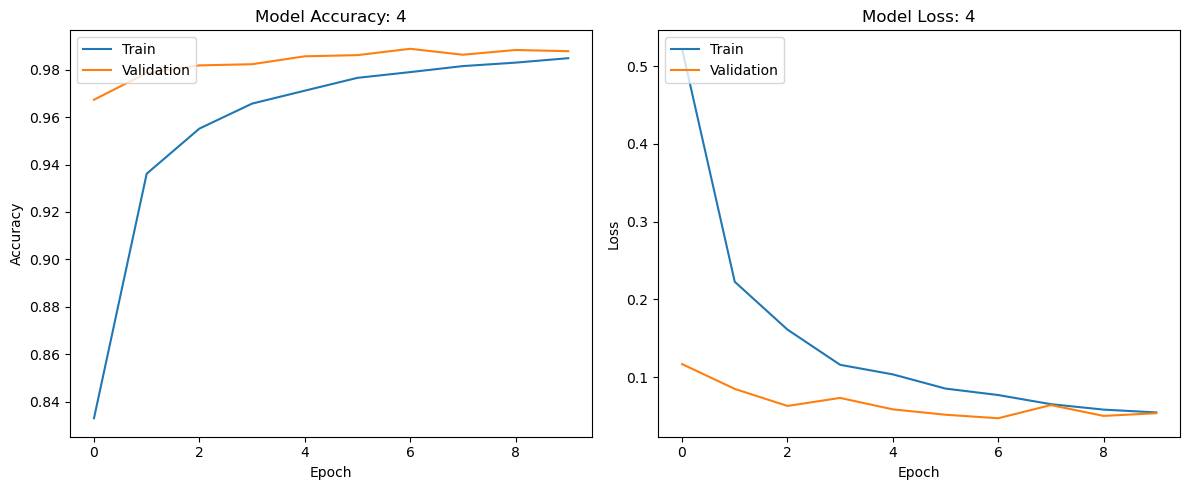

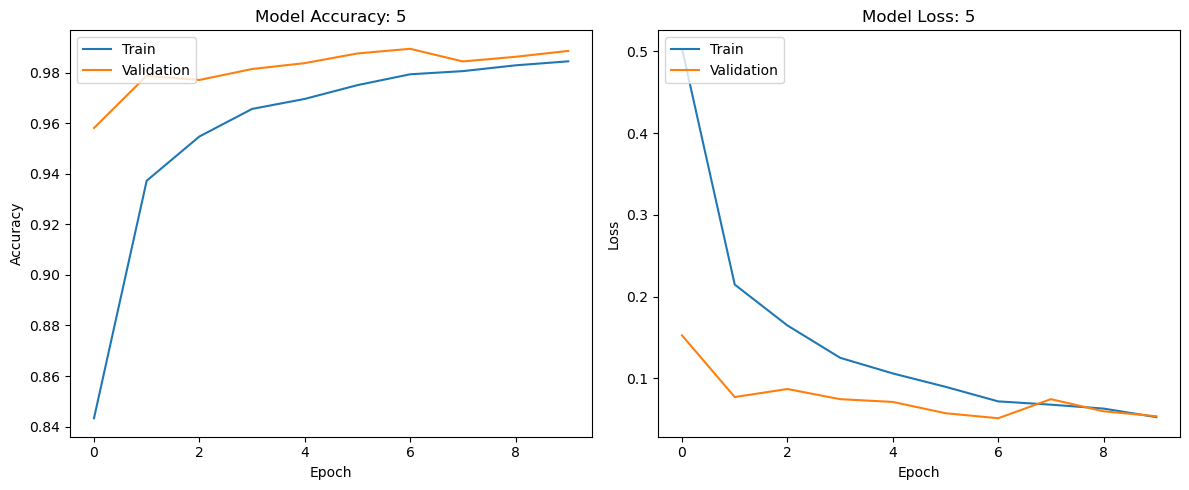

In [26]:
from sklearn.model_selection import KFold

def crossEntropy(train_X, n_folds = 5):
    #divide seus dados em k folds, e treina no k−1 e valida em 1 fold, então a proporção de dados usados para validação é 1/k.
    #2 folds (50% de validação): Treina em 50% dos dados e valida nos outros 50%.
    #5 folds (20% de validação): Treina em 80% dos dados e valida em 20%.
    #10 folds (10% de validação): Treina em 90% dos dados e valida em 10%.    
    n_fold = 5 if n_folds == 0 else n_folds
    
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)  #divisão do conjunto de dados
    fold_no = 1
    for train, test in kf.split(train_X, train_y):
        print(f"Treinando a rede no folder numero: {fold_no}")
        model = criacaoModeloF1() # instanciando o modelo
        inicio = time.time() #tempo de inicio
        history = model.fit(train_X[train], train_y[train], epochs = 10, batch_size = 32, verbose = 1, validation_data = (train_X[test], train_y[test]))
        treinamentoF = time.time() #tempo final
        tempoTreino = round(treinamentoF - inicio,2)
        scores = model.evaluate(train_X[test], train_y[test], verbose = 1)
        print(f"Num do Folder: {fold_no}: Taxa de Loss: {scores[0]}, Taxa de Acuracia: {scores[1]*100:.2f}%, Tamanho do Conjunto de Dados: {len(train_X[train])}, Tempo de Treino: {tempoTreino}")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro gráfico  # Primeiro gráfico (accuracy)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy']) # Métrica de validação
        plt.title(f'Model Accuracy: {fold_no}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo gráfico # Segundo gráfico (loss)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss']) # Métrica de validação
        plt.title(f'Model Loss: {fold_no}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.tight_layout() # Exibir os gráficos       
        fold_no += 1
        print("\n")
        
#carregar os dados    
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
combinado_treino = np.concatenete([train_X, train_y], axis=0)
combinado_validacao = np.concatenete([test_X, test_y], axis=0)

#filtrar com entropia dados de treino e teste apartir da mesma mediana
train_X, train_y, test_X, test_y = filtrar_entropia_median_train_teste(train_X, train_y, test_X, test_y) #novo filtro da reunião 03-10-2023
#normalizar e para categorical

#criar/instanciar o modelo para validação cruzada
crossEntropy(train_X, 5)


# Importando Dados CIFAR-10

* Entropia Global das Imagens (Entropia Aplicada Diretamente flatten)

## Criação e definição de todas as funções

1.   Filtro de Entropia
2.   Carregamento, Preprocesssamento e Tratamento
3.   Criação do Modelo [mesmo modelo do MNIST]
4.   Predições Estatisticas
5.   Plot de Acuracy e Loss

### [CIFAR]Treinamento e ordem de execução das funções
 * **[Modelo selecionado sem entropia]**

In [34]:
from keras import regularizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
def criacaoModeloG8(x_train):
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))

  initial_learning_rate = 0.001
  lr_schedule = ExponentialDecay(
      initial_learning_rate,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)

  opt = SGD(learning_rate=lr_schedule, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

170498071/170498071 [==============================] - 15s 0us/step
Epoch 1/50
391/391 [==============================] - 19s 40ms/step - loss: 2.0802 - accuracy: 0.3773 - val_loss: 2.1577 - val_accuracy: 0.3067
Epoch 2/50
391/391 [==============================] - 14s 37ms/step - loss: 1.5017 - accuracy: 0.5086 - val_loss: 1.6623 - val_accuracy: 0.4541
Epoch 3/50
391/391 [==============================] - 14s 37ms/step - loss: 1.2868 - accuracy: 0.5686 - val_loss: 1.2238 - val_accuracy: 0.5875
Epoch 4/50
391/391 [==============================] - 14s 37ms/step - loss: 1.1700 - accuracy: 0.6077 - val_loss: 1.0521 - val_accuracy: 0.6418
Epoch 5/50
391/391 [==============================] - 14s 37ms/step - loss: 1.1034 - accuracy: 0.6284 - val_loss: 1.0201 - val_accuracy: 0.6562
Epoch 6/50
391/391 [==============================] - 15s 37ms/step - loss: 1.0412 - accuracy: 0.6484 - val_loss: 1.0166 - val_accuracy: 0.6529
Epoch 7/50
391/391 [==============================] - 15s 37ms/step 

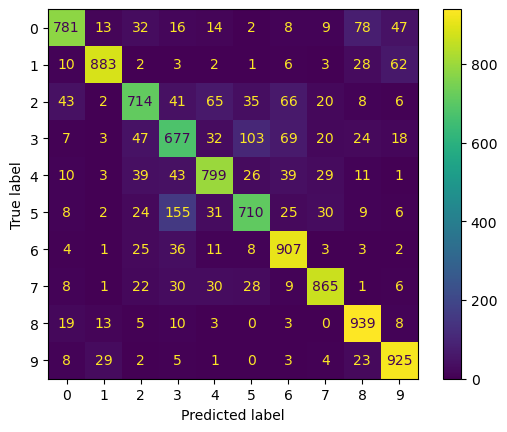

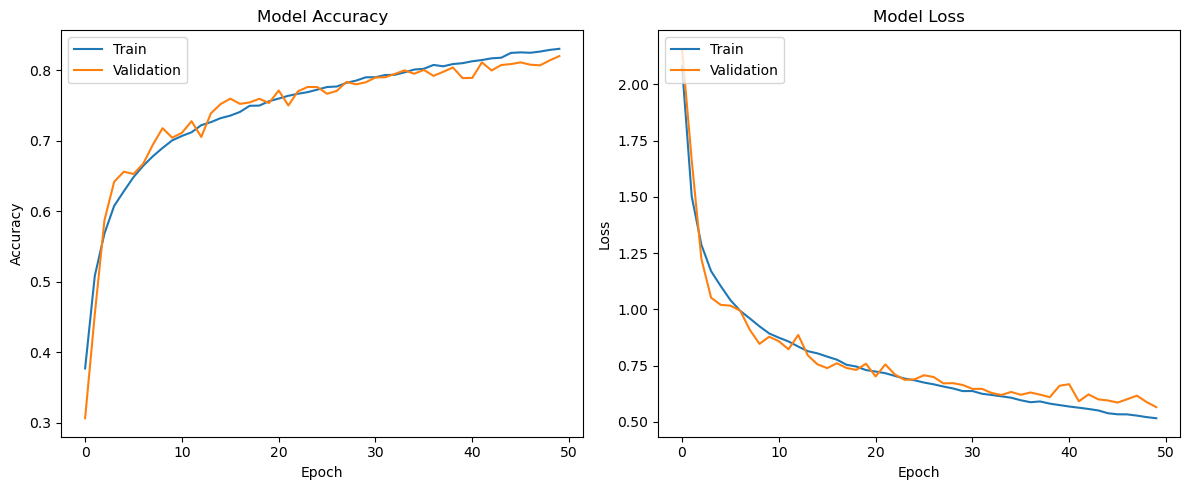

In [13]:
from keras.datasets import cifar10
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
datagen.fit(train_X)
importacaoF = time.time() #tempo de importacao e datagen


train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X) # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
#history = model.fit(train_X, train_y, epochs = 50, batch_size = 128, validation_data=(test_X, test_y), verbose = 1) #treinamento
history = model.fit(datagen.flow(train_X, train_y, batch_size = 128),steps_per_epoch=len(train_X/128), epochs = 50, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

## ajuste para cifar10 com data gen <==================

In [40]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
datagen.fit(train_X)
importacaoF = time.time() #tempo de importacao e datagen


train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X) # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history=model.fit(datagen.flow(train_X, train_y, batch_size=128),
                    steps_per_epoch = len(train_X) / 128, epochs=50, validation_data=(test_X, test_y))
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)


KeyboardInterrupt



  ### [CIFAR]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Divido na metade e aletatorio]**

Epoch 1/50
196/196 [==============================] - 11s 44ms/step - loss: 2.4102 - accuracy: 0.3214 - val_loss: 3.1031 - val_accuracy: 0.1507
Epoch 2/50
196/196 [==============================] - 8s 42ms/step - loss: 1.8151 - accuracy: 0.4182 - val_loss: 1.9592 - val_accuracy: 0.3609
Epoch 3/50
196/196 [==============================] - 8s 39ms/step - loss: 1.5975 - accuracy: 0.4778 - val_loss: 1.3578 - val_accuracy: 0.5363
Epoch 4/50
196/196 [==============================] - 8s 41ms/step - loss: 1.4649 - accuracy: 0.5130 - val_loss: 1.2421 - val_accuracy: 0.5819
Epoch 5/50
196/196 [==============================] - 8s 39ms/step - loss: 1.3472 - accuracy: 0.5466 - val_loss: 1.3219 - val_accuracy: 0.5507
Epoch 6/50
196/196 [==============================] - 8s 41ms/step - loss: 1.2606 - accuracy: 0.5728 - val_loss: 1.2384 - val_accuracy: 0.5887
Epoch 7/50
196/196 [==============================] - 8s 40ms/step - loss: 1.1893 - accuracy: 0.5968 - val_loss: 1.1330 - val_accuracy: 0.617

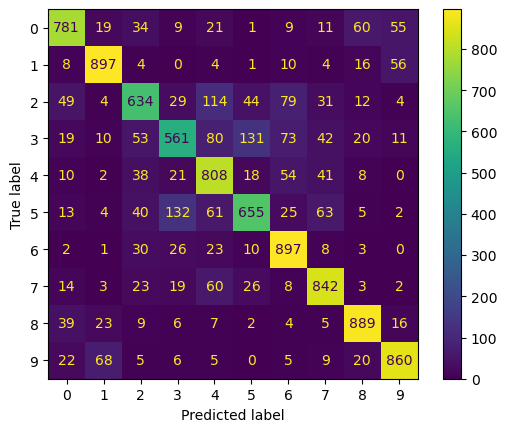

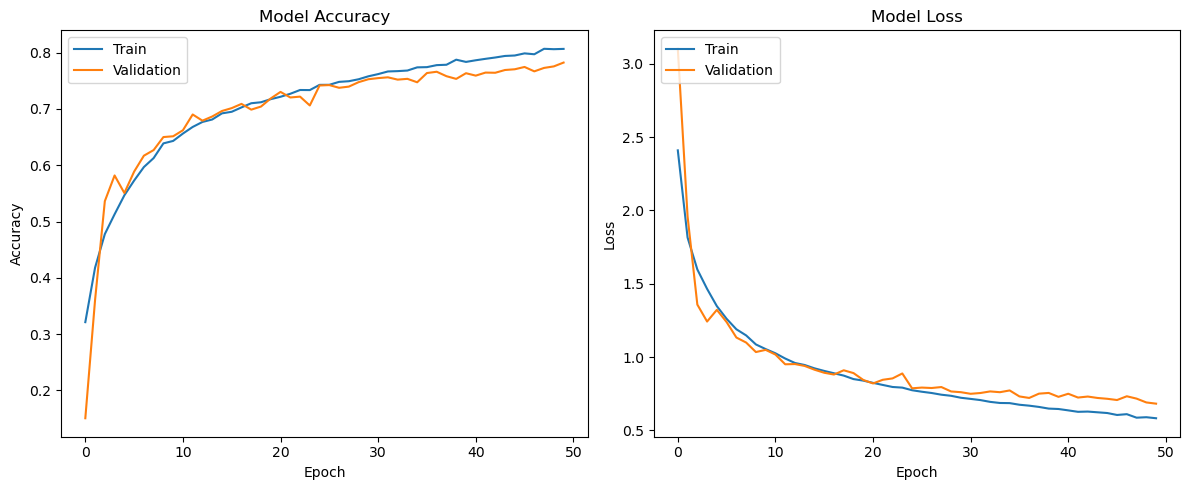

In [14]:
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
import random
def selecionar_metade_aleatoria(metade1, metade2):
    return metade1 if random.choice([True, False]) else metade2

inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
metade_train_X, outra_metade_train_X, metade_train_y, outra_metade_train_y = train_test_split(train_X, train_y, test_size=0.5, random_state=42) # Corte aleatorio do dataset na metade
train_X = selecionar_metade_aleatoria(metade_train_X, outra_metade_train_X)
train_y = selecionar_metade_aleatoria(metade_train_y, outra_metade_train_y)

importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X)
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 50, batch_size = 128, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### [CIFAR]Treinamento e ordem de execução das funções
 * **[Modelo selecionado com entropia]**
 * **[Baixa entropia]**

Epoch 1/50
196/196 [==============================] - 10s 42ms/step - loss: 2.3397 - accuracy: 0.3481 - val_loss: 3.0746 - val_accuracy: 0.1876
Epoch 2/50
196/196 [==============================] - 8s 41ms/step - loss: 1.7241 - accuracy: 0.4626 - val_loss: 2.1146 - val_accuracy: 0.3062
Epoch 3/50
196/196 [==============================] - 8s 41ms/step - loss: 1.5043 - accuracy: 0.5137 - val_loss: 1.4289 - val_accuracy: 0.5135
Epoch 4/50
196/196 [==============================] - 8s 42ms/step - loss: 1.3632 - accuracy: 0.5510 - val_loss: 1.6268 - val_accuracy: 0.4842
Epoch 5/50
196/196 [==============================] - 8s 40ms/step - loss: 1.2643 - accuracy: 0.5791 - val_loss: 1.4794 - val_accuracy: 0.5124
Epoch 6/50
196/196 [==============================] - 8s 41ms/step - loss: 1.1814 - accuracy: 0.6091 - val_loss: 1.3869 - val_accuracy: 0.5393
Epoch 7/50
196/196 [==============================] - 8s 40ms/step - loss: 1.1339 - accuracy: 0.6203 - val_loss: 1.1284 - val_accuracy: 0.615

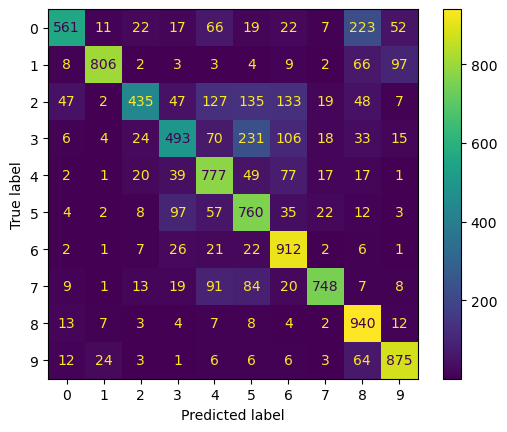

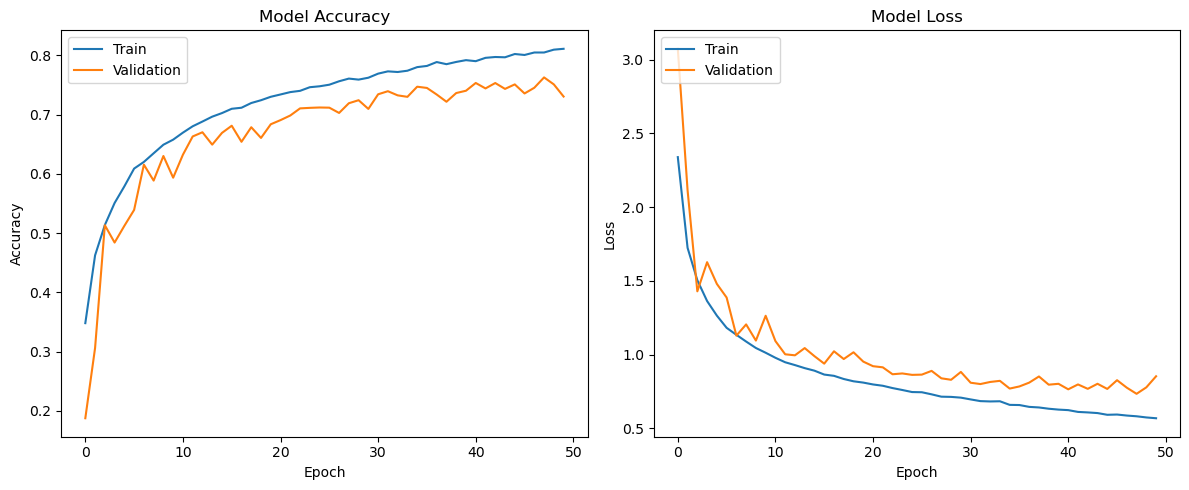

In [15]:
from keras.datasets import cifar10
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X) # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 50, batch_size = 128, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### Filtro de entropia :
  * Dataset filtrado
  * Median transferida para conjunto de treino

### Filtro de entropia :
  * Dataset filtrado
  * Median transferida para conjunto de treino
  * Cross-validation